# Undertaking paper replication - A Graph Neural Network for Decision TSP with PyTorch.
* Paper: [arXiv](https://arxiv.org/pdf/1809.02721.pdf)
* Official repo: [GitHub](https://github.com/machine-reasoning-ufrgs/TSP-GNN)

## 0. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.auto import tqdm

print(f'PyTorch version: {torch.__version__}')

PyTorch version: 2.2.1


## 1. MLP layer & GraphNN model
<img src="https://raw.githubusercontent.com/Panichito/GNN-Decision-TSP/main/fig/algorithm1.png" width=315 alt="algo1 GNN TSP solver"/>

In [2]:
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim, activation=nn.ReLU(), output_activation=None, name=None):
        super().__init__()

        layer_sizes = [input_dim] + [hidden_dim] * (num_layers-1) + [output_dim]
        activations = [activation] * (num_layers-1) + [output_activation]

        self.layers = nn.ModuleList([
            nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)
        ])
        self.activations = nn.ModuleList(activations)

    def forward(self, x):
        for layer, activation in zip(self.layers[:-1], self.activations):
            x = activation(layer(x))
        if self.activations[-1] is not None:
            return self.activations[-1](self.layers[-1](x))
        else:
            return self.layers[-1](x)

In [3]:
class GraphNN(nn.Module):
    def __init__(self, var, mat, msg, loop, MLP_depth=3, Msg_last_activation=None, name='GraphNN'):
        super().__init__()
        self.var, self.mat, self.msg, self.loop, self.name = var, mat, msg, loop, name

        self.MLP_depth = MLP_depth
        self.Msg_last_activation = Msg_last_activation

        self._init_parameters()

        # Define a MLP to compute initial edge embeddings
        self.hidden_dim = self.var['V']  # hidden dimension for easy access
        self.edge_init_MLP = MLP(
            num_layers=self.MLP_depth,
            input_dim=2,
            hidden_dim=self.hidden_dim,
            output_dim=self.hidden_dim,
            activation=nn.ReLU(),
            output_activation=self.Msg_last_activation,
            name='E_init_MLP'
        )
        # Define E_vote MLP
        self.E_vote_MLP = MLP(
            num_layers=self.MLP_depth,
            input_dim=self.hidden_dim,
            hidden_dim=self.hidden_dim,
            output_dim=1,
            activation=nn.ReLU(),
            output_activation=self.Msg_last_activation,
            name='E_vote'
        )

    def forward(self, matrices, forward_time_steps=32):
        # Initialize edge embeddings
        edge_initial_embeddings = self.edge_init_MLP(torch.cat((matrices['W'], matrices['C']), dim=1))

        # Initialize vertex embeddings
        total_n = matrices['EV'].size(1)
        v_init = torch.randn((1, self.hidden_dim))
        vertex_initial_embeddings = v_init / torch.sqrt(torch.tensor(self.hidden_dim, dtype=torch.float32)).repeat(total_n, 1)
        initial_embeddings = {"V": vertex_initial_embeddings, "E": edge_initial_embeddings}

        states = {}
        for v, init_emb in initial_embeddings.items():
            h0 = init_emb
            c0 = torch.zeros_like(h0, dtype=torch.float32)
            states[v] = (h0, c0)  # hidden state (short-term), cell state (long-term)

        for t in range(forward_time_steps):
            for v in self.var:
                inputs = []
                #print(f">> LOOP {v}_({t})")
                for update in self.loop[v]:
                    #print(f"FOUND update = {update}")
                    if 'var' in update:
                        y = states[update['var']][0]  # hx
                        if 'msg' in update:
                            y = self._msg_MLPs[update['msg']](y)  # E_msg_V(E(t)) or V_msg_E(V(t))
                        if 'mat' in update:
                            if 'transpose?' in update and update['transpose?'] == True:
                                y = torch.matmul(matrices[update['mat']].t(), y)  # EVᵀ × E_msg_V(E(t))
                            else:
                                y = torch.matmul(matrices[update['mat']], y)  # EV × V_msg_E(V(t))
                        inputs.append(y)  # EVᵀ × E_msg_V(E(t)) or EV × V_msg_E(V(t))
                    else:
                        inputs.append(matrices[update['mat']])

                #print(inputs[0].shape)
                inputs = torch.cat(inputs, dim=1)
                #print(inputs.shape)
                hx, cx = states[v]

                #print(cx)  # ไม่งั้นค่า cx จะเป็น 0 ตลอดเวลา t
                new_h, new_c = self._RNN_cells[v](inputs, (hx, cx))  # UPDATE STATES: V(t+1) ← LSTM(EVᵀ × E_msg_V(E(t))) or E(t+1) ← LSTM(EV × V_msg_E(V(t)))
                states[v] = (new_h, new_c)
                #states[v] = (torch.relu(new_h), new_c)

            last_states = states

        E_n = last_states['E'][0]  # last state hx
        #print(f'E_n: {E_n.shape}')
        #print(f'E_n: {E_n.view(-1, self.hidden_dim).shape}')

        # Compute a vote for each embedding
        E_vote = self.E_vote_MLP(E_n.view(-1, self.hidden_dim))
        #print(f'E_vote: {E_vote.shape}')
        E_vote = E_vote.view(-1)
        #print(f'E_vote: {E_vote.shape}')
        #print(f'E_vote: {E_vote}')

        # Compute the number of problems in the batch
        num_problems = matrices['n_vertices'].size(0)
        n_edges = matrices['n_edges']
        n_edges_np = n_edges.cpu().numpy()

        # Compute a logit probability for each problem
        pred_logits = []
        for i in range(num_problems):
            start_index = int(n_edges_np[0:i].sum())
            end_index = start_index + int(n_edges[i])
            #print(start_index, end_index)
            logits = E_vote[start_index:end_index].mean()
            pred_logits.append(logits)
        pred_logits = torch.stack(pred_logits)
        predictions = torch.sigmoid(pred_logits)

        # Convert logits into probabilities
        #print(f"\nLogits: {pred_logits}")
        #print(f"Pred prob: {predictions}")
        #print(f"Target: {matrices['route_exists']}")

        return predictions

    def _init_parameters(self):
        self._RNN_cells = nn.ModuleDict()
        for v, H in self.var.items():
            #print(f"v = {i}, H = {H}")
            if v == 'V':
                self._RNN_cells[v] = nn.LSTMCell(input_size=H, hidden_size=H)
            elif v == 'E':
                self._RNN_cells[v] = nn.LSTMCell(input_size=H, hidden_size=H)
        #print(self._RNN_cells)

        self._msg_MLPs = nn.ModuleDict()
        for msg, (vin, vout) in self.msg.items():
            #print(f"msg = {msg}, vin = {vin}, vout = {vout}")
            if msg == "V_msg_E":
                self._msg_MLPs[msg] = MLP(
                    num_layers=self.MLP_depth,
                    input_dim=self.var[vin],
                    hidden_dim=self.var[vin],
                    output_dim=self.var[vout],
                    activation=nn.ReLU(),
                    output_activation=self.Msg_last_activation,
                    name=msg)
            elif msg == "E_msg_V":
                self._msg_MLPs[msg] = MLP(
                    num_layers=self.MLP_depth,
                    input_dim=self.var[vin],
                    hidden_dim=self.var[vin],
                    output_dim=self.var[vout],
                    activation=nn.ReLU(),
                    output_activation=self.Msg_last_activation,
                    name=msg)
        #print(self._msg_LPs)

## 2. Creating the [Decision TSP](https://arxiv.org/abs/1809.02721) model

In [4]:
def build_network(hidden_dim, MLP_depth):
    H = hidden_dim
    var = {'V': H, 'E': H}      # V is the set of vertex embeddings, E is the set of edge embeddings
    mat = {'EV': ('E', 'V')}    # M is a E×V adjacency matrix connecting each edge to the vertices it is connected to
    msg = {
        'V_msg_E': ('V', 'E'),  # V_msg_E is a MLP which computes messages from vertex embeddings to edge embeddings
        'E_msg_V': ('E', 'V')}  # E_msg_V is a MLP which computes messages from edge embeddings to vertex embeddings
    loop ={
        'V': [{                 # V(t+1) ← Vu( EVᵀ × E_msg_V(E(t)) )
            'mat': 'EV', 
            'transpose?': True, 
            'msg': 'E_msg_V', 
            'var': 'E'}], 
        'E': [{                 # E(t+1) ← Eu( EV × V_msg_E(V(t)) )
            'mat': 'EV', 
            'msg': 'V_msg_E', 
            'var': 'V'}]}
    gnn = GraphNN(var=var, mat=mat, msg=msg, loop=loop, MLP_depth=MLP_depth)

    return gnn

## 3. Datasets

In [5]:
from gen.instance_loader import InstanceLoader
from itertools import islice  # islice(iterable, start, stop, step)

train_loader = InstanceLoader('gen/tmp/train')
test_loader = InstanceLoader('gen/tmp/test')

## 4. Model, loss, and optimizer

In [6]:
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5
L2_NORM_SCALING = 1e-10
GLOBAL_NORM_GRADIENT_CLIPPING_RATION = 0.65

torch.manual_seed(42)

GNN = build_network(hidden_dim=64, MLP_depth=3)
loss_fn = nn.BCELoss()
#optimizer = torch.optim.Adam(params=GNN.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(params=GNN.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

summary(GNN, col_names=["num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                  Param #                   Trainable
GraphNN (GraphNN)                        --                        True
├─ModuleDict (_RNN_cells)                --                        True
│    └─LSTMCell (V)                      33,280                    True
│    └─LSTMCell (E)                      33,280                    True
├─ModuleDict (_msg_MLPs)                 --                        True
│    └─MLP (V_msg_E)                     --                        True
│    │    └─ModuleList (layers)          12,480                    True
│    │    └─ModuleList (activations)     --                        --
│    └─MLP (E_msg_V)                     --                        True
│    │    └─ModuleList (layers)          12,480                    True
│    │    └─ModuleList (activations)     --                        --
├─MLP (edge_init_MLP)                    --                        True
│    └─ModuleList (layers)               --                    

## 5. Training

In [7]:
def run_batch(model, loss_fn, optimizer, batch, batch_i, epoch_i, train=False, forward_time_steps=32, print_every=1, device='cpu', verbose=False):
    if train:
        model.train()
    else:
        model.eval()
    EV, W, C, route_exists, n_vertices, n_edges = batch
    EV = torch.tensor(EV, dtype=torch.float32, device=device)
    W = torch.tensor(W, dtype=torch.float32, device=device)
    C = torch.tensor(C, dtype=torch.float32, device=device)
    route_exists = torch.tensor(route_exists, dtype=torch.float32, device=device)
    n_vertices = torch.tensor(n_vertices, dtype=torch.float32, device=device)
    n_edges = torch.tensor(n_edges, dtype=torch.float32, device=device)

    # Forward pass
    outputs = model(matrices={"EV": EV, 
                                'W': W, 
                                'C': C, 
                                'route_exists': route_exists, 
                                'n_vertices': n_vertices, 
                                'n_edges': n_edges}, 
                    forward_time_steps=forward_time_steps)

    # Compute loss
    loss = loss_fn(outputs, route_exists)
    if train:
        # Compute cost relative to L2 normalization
        vars_cost = sum(p.norm(2).pow(2) for p in model.parameters())
        #print(f"vars_cost = {vars_cost:.4f}")

        # Define gradients and train step
        optimizer.zero_grad()
        #loss = loss + vars_cost * L2_NORM_SCALING
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), GLOBAL_NORM_GRADIENT_CLIPPING_RATION)
        optimizer.step()

    # Compute True Positives, False Positives, True Negatives, False Negatives, accuracy
    TP = (route_exists * (route_exists == torch.round(outputs))).sum()
    FP = (route_exists * (route_exists != torch.round(outputs))).sum()
    TN = ((1 - route_exists) * (route_exists == torch.round(outputs))).sum()
    FN = ((1 - route_exists) * (route_exists != torch.round(outputs))).sum()
    acc = torch.mean((route_exists == torch.round(outputs)).float())
    #print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}, acc: {acc}")

    if epoch_i % print_every == 0:
        #print(f" V = {n_vertices}, E = {n_edges}, route_exists = {route_exists} (TP & TN for each graph)\n EV = {EV.shape}, W = {W.shape}, C = {C.shape}")
        print("Epoch: {epoch_i:5d} | {train_or_test} Loss: {loss:.4f} | {train_or_test} Acc: {acc:.2f}%".format(epoch_i=epoch_i, train_or_test='Train' if train else 'Test', loss=loss, acc=acc*100))
        if not train and verbose:
            print(f"Outputs: {outputs}")
            #print(f"Route exists: {route_exists}")
            #print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

    return loss.detach().numpy(), acc.detach().numpy()

In [8]:
BATCH_SIZE = 5
BATCH_PER_EPOCH = 1
EPOCHS = 3001
DEVIATION = 0.02

all_train_loss, all_train_acc, all_test_loss, all_test_acc = [], [], [], []
print_every = 200
lstm_time_step = 3

for epoch_i in tqdm(range(EPOCHS)):
    train_loader.reset()
    for (batch_i, batch) in islice(enumerate(train_loader.get_batches(BATCH_SIZE, DEVIATION)), BATCH_PER_EPOCH):
        #print(f"Batch {batch_i}")
        train_loss, train_acc = run_batch(GNN, loss_fn, optimizer, batch, batch_i, epoch_i, train=True, forward_time_steps=lstm_time_step, print_every=print_every)
        if epoch_i % print_every==0:
            all_train_loss.append(train_loss)
            all_train_acc.append(train_acc)

    if epoch_i % print_every==0:
        test_loader.reset()
        for (batch_i, batch) in islice(enumerate(test_loader.get_batches(1, DEVIATION)), 1):
            #print(f"Batch {batch_i}")
            test_loss, test_acc = run_batch(GNN, loss_fn, optimizer, batch, batch_i, epoch_i, train=False, forward_time_steps=lstm_time_step, print_every=print_every)
            all_test_loss.append(test_loss)
            all_test_acc.append(test_acc)

  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch:     0 | Train Loss: 0.6934 | Train Acc: 50.00%
Epoch:     0 | Test Loss: 0.6934 | Test Acc: 50.00%
Epoch:   200 | Train Loss: 0.6931 | Train Acc: 60.00%
Epoch:   200 | Test Loss: 0.6931 | Test Acc: 50.00%
Epoch:   400 | Train Loss: 0.6667 | Train Acc: 60.00%
Epoch:   400 | Test Loss: 0.6468 | Test Acc: 50.00%
Epoch:   600 | Train Loss: 0.5044 | Train Acc: 80.00%
Epoch:   600 | Test Loss: 0.4051 | Test Acc: 100.00%
Epoch:   800 | Train Loss: 0.4141 | Train Acc: 70.00%
Epoch:   800 | Test Loss: 0.1552 | Test Acc: 100.00%
Epoch:  1000 | Train Loss: 0.1471 | Train Acc: 100.00%
Epoch:  1000 | Test Loss: 0.2069 | Test Acc: 100.00%
Epoch:  1200 | Train Loss: 0.0909 | Train Acc: 100.00%
Epoch:  1200 | Test Loss: 0.0750 | Test Acc: 100.00%
Epoch:  1400 | Train Loss: 0.0375 | Train Acc: 100.00%
Epoch:  1400 | Test Loss: 0.0237 | Test Acc: 100.00%
Epoch:  1600 | Train Loss: 0.0324 | Train Acc: 100.00%
Epoch:  1600 | Test Loss: 0.0286 | Test Acc: 100.00%
Epoch:  1800 | Train Loss: 0.0313 | 

## 6. Visualization (loss curve)

In [9]:
def visualize_loss_curve(train_loss, test_loss, train_acc=None, test_acc=None, print_every=1, fixed_axis=None, title_name="nameless"):
    plt.figure(figsize=(7, 4))
    plt.plot([i * print_every for i in range(len(train_loss))], train_loss, label=f'Train Loss', lw=1.6, c='royalblue')
    plt.plot([i * print_every for i in range(len(test_loss))], test_loss, label=f'Test Loss', lw=1.2, c='orange')
    if train_acc != None:
        plt.plot([i * print_every for i in range(len(train_acc))], train_acc, label=f'Train Acc', lw=1.6, c='r', linestyle='--')
    if test_acc != None:
        plt.plot([i * print_every for i in range(len(test_acc))], test_acc, label=f'Test Acc', lw=1.2, c='g', linestyle='--')
    
    plt.title(title_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if fixed_axis != None:
        plt.ylim(fixed_axis[0], fixed_axis[1])
    plt.grid(True)
    plt.show()

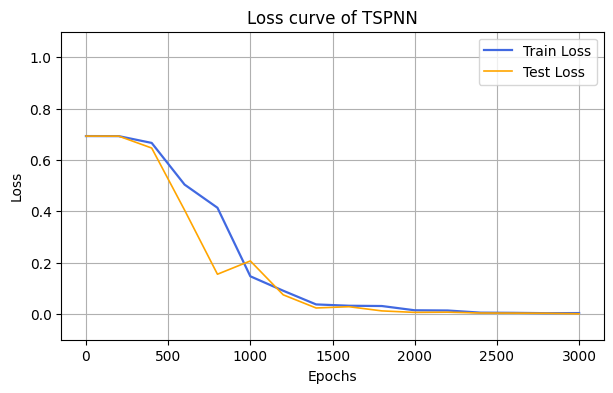

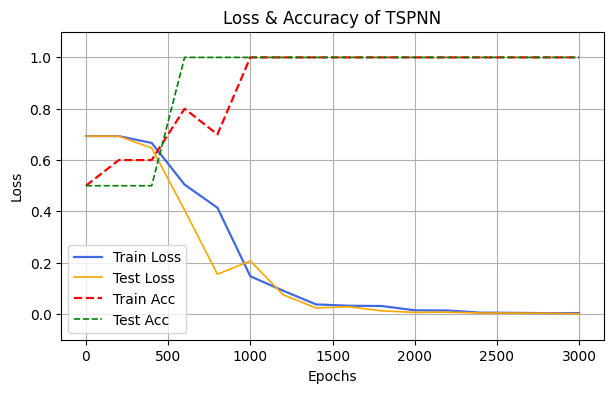

In [10]:
axis=[-0.1, 1.1]

visualize_loss_curve(all_train_loss, all_test_loss, print_every=print_every, fixed_axis=axis, title_name="Loss curve of TSPNN")
visualize_loss_curve(all_train_loss, all_test_loss, all_train_acc, all_test_acc, print_every=print_every, fixed_axis=axis, title_name="Loss & Accuracy of TSPNN")

Compared with BCE loss curve from the official paper of $2^{20}$ graphs with $n \sim \mathcal{U}(20, 40)$

<img src="https://raw.githubusercontent.com/Panichito/GNN-Decision-TSP/main/fig/BCEloss_official.png" width=500 alt="loss figure from paper"/>